<a href="https://colab.research.google.com/github/olusipedaniel/kaggle_competitions/blob/main/Paddy_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the data from kaggle

In [1]:
# Importting tensorflow
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
# Uploading .json files
from google.colab import files
files.upload()

In [3]:
# Create a kaggle folder
! mkdir ~/.kaggle

# Copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

# Permission for the json file to act
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# List all competition datasets in kaggle
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         55           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         96           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        610           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        128           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1243           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      15132           False  
house-pr

In [5]:
# Downloading dataset
! kaggle competitions download -c paddy-disease-classification

 99% 1.01G/1.02G [00:04<00:00, 204MB/s]
100% 1.02G/1.02G [00:04<00:00, 229MB/s]


In [ ]:
# Unzipping downloaded data
! unzip paddy-disease-classification.zip

### Preprocessing (preparing it for the model) and becoming one with the data

In [7]:
# Setting up paths to directories
train_dir="train_images"
test_dir="test_images"

In [8]:
# Checking the number of images in the training image directory
import os

for dirpath,dirnames,filenames in os.walk("train_images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 10 directories and 0 images in train_images.
There are 0 directories and 479 images in train_images/bacterial_leaf_blight.
There are 0 directories and 1594 images in train_images/hispa.
There are 0 directories and 620 images in train_images/downy_mildew.
There are 0 directories and 1738 images in train_images/blast.
There are 0 directories and 1764 images in train_images/normal.
There are 0 directories and 380 images in train_images/bacterial_leaf_streak.
There are 0 directories and 337 images in train_images/bacterial_panicle_blight.
There are 0 directories and 1442 images in train_images/dead_heart.
There are 0 directories and 1088 images in train_images/tungro.
There are 0 directories and 965 images in train_images/brown_spot.


In [9]:
# Loading image data into batches from directory created above

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       batch_size=BATCH_SIZE,
                                                       subset="training")

valid_data=tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       seed=42,
                                                       validation_split=0.2,
                                                       batch_size=BATCH_SIZE,
                                                       subset="validation")

test_data=tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                      label_mode=None,
                                                      image_size=IMG_SIZE,
                                                      seed=42,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.
Found 3469 files belonging to 1 classes.


In [10]:
# Getting class_names
class_names=train_data.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [11]:
# Creating a function to visualize random images from train_data
# Importting matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(target_dir):
  plt.figure(figsize=(8,8))
  for i in range(4):
    plt.subplot(2,2,i+1)
    target_class=random.choice(class_names)
    target_folder=target_dir+"/"+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    print(random_image)
    target_image=target_dir+"/"+target_class+"/"+random_image[0]

    # Reading in and plotting image using matplotlib
    img=mpimg.imread(target_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

['100674.jpg']
['107624.jpg']
['105912.jpg']
['102336.jpg']


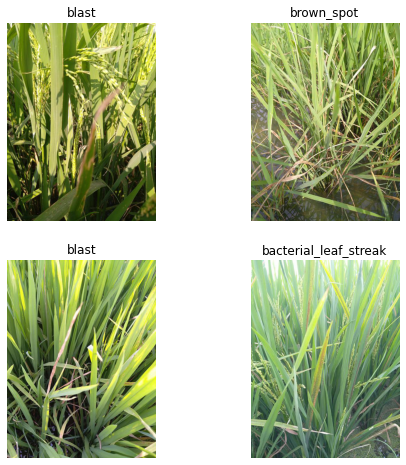

In [12]:
# Visualizing random images from train_data
view_random_images("train_images")

### Creating a transfer learning feature extraction model

In [13]:
# Creating Reduce learning rate callback
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                               factor=0.1,
                                               patience=2, 
                                               min_lr=0.001,
                                               verbose=1)

# Creating ModelCheckpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint/',
                                                    save_weights_only=True,
                                                    save_freq="epoch")

In [14]:
# Importing mixed precision
from tensorflow.keras import mixed_precision

# Setting up mixed precision training
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

In [15]:
# Creating a non-trainable base model
base_model=tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

# Creating a functional model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=base_model(inputs)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.Dense(256,activation="relu")(x)
x=tf.keras.layers.Dense(len(train_data.class_names))(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32)(x)
model=tf.keras.Model(inputs,outputs)

# Compiling model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

initial_epoch=20
# Fitting model
history=model.fit(train_data,
                  epochs=initial_epoch,
                  steps_per_epoch=len(train_data),
                  validation_data=valid_data,
                  validation_steps=len(valid_data),
                  callbacks=[reduce_lr,model_checkpoint])

71696384/71686520 [==============================] - 0s 0us/step
Epoch 1/20
261/261 [==============================] - 73s 193ms/step - loss: 1.4490 - accuracy: 0.5037 - val_loss: 1.1052 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 2/20
261/261 [==============================] - 39s 149ms/step - loss: 1.0434 - accuracy: 0.6428 - val_loss: 0.9213 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 3/20
261/261 [==============================] - 41s 153ms/step - loss: 0.8625 - accuracy: 0.7009 - val_loss: 0.7553 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/20
261/261 [==============================] - 41s 154ms/step - loss: 0.7209 - accuracy: 0.7574 - val_loss: 0.7713 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 5/20
261/261 [==============================] - 41s 154ms/step - loss: 0.6225 - accuracy: 0.7863 - val_loss: 0.6104 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 6/20
261/261 [==============================] - 41s 153ms/step - loss: 0.5743 - accuracy: 0.8016 - val_loss: 0.5339 - val_accuracy: 0.8241 

In [16]:
# Evaluating model
model.evaluate(valid_data)

66/66 [==============================] - 8s 117ms/step - loss: 0.3268 - accuracy: 0.8996


[0.326781690120697, 0.8995675444602966]

In [17]:
# Creating function to plot training and validation curves seperately
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  # Plotting loss curves
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss curves")
  plt.xlabel("Epochs")
  plt.legend();

  # Plotting accuracy curves
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy curves")
  plt.xlabel("Epochs")
  plt.legend();

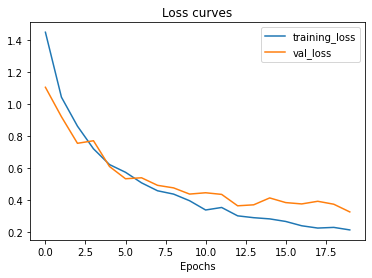

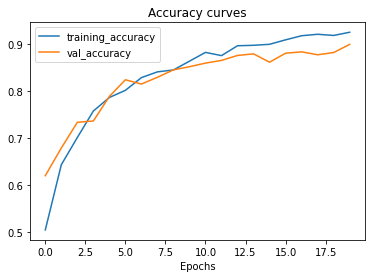

In [18]:
# Plotting model's loss curve
plot_loss_curves(history)

### Fine tuning base_model by setting the base_model to trainable and freezing the all layers except the last 10 layers 

In [19]:
# Setting base_model to trainable
base_model.trainable=True

# Freezing all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [20]:
# Checking base_model
for num,layer in enumerate(base_model.layers):
  print(num,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [21]:
# Re-compiling fine-tuned model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics="accuracy")

In [22]:
fine_tune_epoch=initial_epoch+20
# Fitting fine-tuned model
history_last_10_layers=model.fit(train_data,
                                 epochs=fine_tune_epoch,
                                 steps_per_epoch=len(train_data),
                                 validation_data=valid_data,
                                 validation_steps=len(valid_data),
                                 initial_epoch=history.epoch[-1],
                                 callbacks=[reduce_lr])

Epoch 20/40
261/261 [==============================] - 56s 165ms/step - loss: 0.5545 - accuracy: 0.8696 - val_loss: 0.3172 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 21/40
261/261 [==============================] - 41s 154ms/step - loss: 0.2321 - accuracy: 0.9246 - val_loss: 0.2880 - val_accuracy: 0.9159 - lr: 1.0000e-04
Epoch 22/40
261/261 [==============================] - 41s 154ms/step - loss: 0.1692 - accuracy: 0.9425 - val_loss: 0.2685 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 23/40
261/261 [==============================] - 41s 154ms/step - loss: 0.1406 - accuracy: 0.9544 - val_loss: 0.2697 - val_accuracy: 0.9322 - lr: 1.0000e-04
Epoch 24/40
261/261 [==============================] - 41s 154ms/step - loss: 0.1250 - accuracy: 0.9582 - val_loss: 0.2396 - val_accuracy: 0.9313 - lr: 1.0000e-04
Epoch 25/40
261/261 [==============================] - 43s 163ms/step - loss: 0.1204 - accuracy: 0.9608 - val_loss: 0.2447 - val_accuracy: 0.9313 - lr: 1.0000e-04
Epoch 26/40
261/261 [=

In [23]:
result_last_10_layers=model.evaluate(valid_data)
result_last_10_layers

66/66 [==============================] - 8s 118ms/step - loss: 0.2201 - accuracy: 0.9457


[0.22014035284519196, 0.945699155330658]

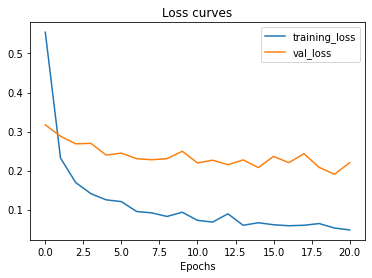

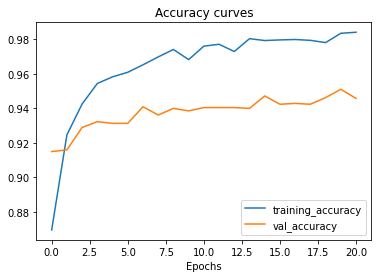

In [24]:
# Plotting loss curves
plot_loss_curves(history_last_10_layers)

### Fine tuning base_model by setting the base_model to trainable and freezing the all layers except the last 20 layers

In [25]:
# Loading the weights saved earlier
model.load_weights("model_checkpoint/")

In [26]:
model.evaluate(valid_data)

66/66 [==============================] - 8s 116ms/step - loss: 0.3268 - accuracy: 0.8996


[0.32678166031837463, 0.8995675444602966]

In [27]:
# Setting base_model to trainable
base_model.trainable=True

# Freezing all layers except the last 20 layers
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [28]:
# Checking base_model
for num,layer in enumerate(base_model.layers):
  print(num,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [29]:
# Re-compiling fine-tuned model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics="accuracy")

In [30]:
# Fitting fine-tuned model
history_last_20_layers=model.fit(train_data,
                                 epochs=fine_tune_epoch,
                                 steps_per_epoch=len(train_data),
                                 validation_data=valid_data,
                                 validation_steps=len(valid_data),
                                 initial_epoch=history.epoch[-1],
                                 callbacks=[reduce_lr])

Epoch 20/40
261/261 [==============================] - 57s 170ms/step - loss: 0.5212 - accuracy: 0.8759 - val_loss: 0.3038 - val_accuracy: 0.9260 - lr: 1.0000e-04
Epoch 21/40
261/261 [==============================] - 42s 160ms/step - loss: 0.2161 - accuracy: 0.9329 - val_loss: 0.2709 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 22/40
261/261 [==============================] - 42s 160ms/step - loss: 0.1471 - accuracy: 0.9550 - val_loss: 0.2545 - val_accuracy: 0.9370 - lr: 1.0000e-04
Epoch 23/40
261/261 [==============================] - 42s 159ms/step - loss: 0.1191 - accuracy: 0.9611 - val_loss: 0.2392 - val_accuracy: 0.9395 - lr: 1.0000e-04
Epoch 24/40
261/261 [==============================] - 42s 159ms/step - loss: 0.1123 - accuracy: 0.9608 - val_loss: 0.2324 - val_accuracy: 0.9390 - lr: 1.0000e-04
Epoch 25/40
261/261 [==============================] - 42s 160ms/step - loss: 0.1064 - accuracy: 0.9665 - val_loss: 0.2322 - val_accuracy: 0.9438 - lr: 1.0000e-04
Epoch 26/40
261/261 [=

In [31]:
# Evaluating model
result_last_20_layers=model.evaluate(valid_data)
result_last_20_layers

66/66 [==============================] - 8s 118ms/step - loss: 0.2274 - accuracy: 0.9467


[0.22735705971717834, 0.9466602802276611]

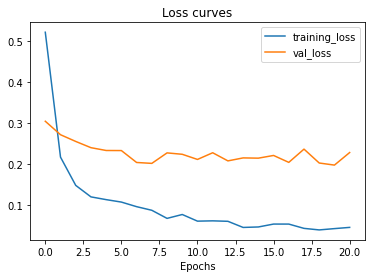

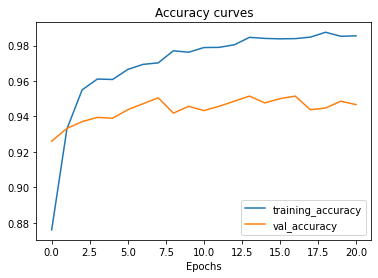

In [32]:
# Plotting model's loss curve
plot_loss_curves(history_last_20_layers)

In [33]:
# Making predictions on test_data
pred_prob=model.predict(test_data,batch_size=32,verbose=1)
pred_prob

109/109 [==============================] - 15s 114ms/step


array([[4.0706464e-08, 8.0131859e-11, 2.0260505e-11, ..., 9.9485320e-01,
        1.0529138e-06, 1.0455846e-07],
       [1.7149313e-11, 1.7545518e-15, 3.7887767e-13, ..., 5.1228977e-07,
        9.9999952e-01, 2.1752108e-08],
       [4.7439230e-09, 2.2891934e-10, 7.1924319e-08, ..., 3.6165815e-08,
        1.0747736e-05, 2.1222471e-07],
       ...,
       [8.1495026e-11, 4.2508477e-14, 1.3121090e-12, ..., 1.0011971e-05,
        9.9998963e-01, 6.6404344e-09],
       [4.4830785e-11, 9.9999893e-01, 1.6329612e-12, ..., 7.3514563e-08,
        8.9122835e-07, 7.5626282e-08],
       [4.1524201e-14, 1.4859421e-16, 2.2822627e-10, ..., 1.5016448e-11,
        2.2938689e-12, 1.5793980e-13]], dtype=float32)

In [34]:
# Getting the highest predicted probabilites
pred=pred_prob.argmax(axis=1)
pred,pred.shape

(array([7, 8, 3, ..., 8, 1, 5]), (3469,))

In [35]:
# Getting class_names for the predicted class
pred_class=[class_names[x] for x in pred]

# Viewing first 10 predictions
pred_class[:10]

['hispa',
 'normal',
 'blast',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

In [36]:
import pandas as pd
predictions=pd.read_csv("sample_submission.csv")
predictions["label"]=pred_class
predictions.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [37]:
predictions.to_csv('efficientb4_submission.csv',header=True,index = False)
#files.download("efficientb4_submission.csv")

In [38]:
! kaggle competitions submit -c paddy-disease-classification -f efficientb4_submission.csv -m "Paddy Disease Classification"